In [60]:
!nvidia-smi

Sat Mar 29 08:22:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   28C    P0             60W /  300W |   20163MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [2]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.3.1 transformers==4.48.3 datasets==2.20.0 accelerate==0.31.0 bitsandbytes==0.43.1 peft==0.11.1 trl==0.9.4 colored==2.2.4 pathos dill multiprocess --progress-bar off

In [3]:
!pip uninstall -y dill multiprocess
!pip install -U dill==0.3.9 multiprocess==0.70.17

Found existing installation: dill 0.3.8
Uninstalling dill-0.3.8:
  Successfully uninstalled dill-0.3.8
Found existing installation: multiprocess 0.70.16
Uninstalling multiprocess-0.70.16:
  Successfully uninstalled multiprocess-0.70.16
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.17-py310-none-any.whl.metadata (7.2 kB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)
Using cached multiprocess-0.70.17-py310-none-any.whl (134 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.20.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.3.9 which is incompatible.


In [4]:
!pip install --upgrade accelerate==0.34.2

  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.31.0
    Uninstalling accelerate-0.31.0:
      Successfully uninstalled accelerate-0.31.0


In [1]:
import accelerate
print(accelerate.__version__)

0.34.2


In [2]:
import torch
import transformers
import bitsandbytes
import accelerate
import peft
import trl
import datasets
import triton
import pathos
import dill
import multiprocess

print("Torch version:", torch.__version__)
print("Transformers version:", transformers.__version__)
print("BitsAndBytes version:", bitsandbytes.__version__)
print("Accelerate version:", accelerate.__version__)
print("PEFT version:", peft.__version__)
print("TRL version:", trl.__version__)
print("Datasets version:", datasets.__version__)
print("Triton version:", triton.__version__)
print("Pathos version:", pathos.__version__)
print("Dill version:", dill.__version__)
print("Multiprocess version:", multiprocess.__version__)

Torch version: 2.3.1+cu121
Transformers version: 4.48.3
BitsAndBytes version: 0.45.4
Accelerate version: 0.34.2
PEFT version: 0.11.1
TRL version: 0.9.4
Datasets version: 3.5.0
Triton version: 2.3.1
Pathos version: 0.3.2
Dill version: 0.3.8
Multiprocess version: 0.70.16


In [47]:
!pip install --upgrade bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
import bitsandbytes as bnb
print(bnb.__version__)

0.45.4


In [4]:
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA Available: True
CUDA Device Count: 1
Current Device: 0
Device Name: NVIDIA A10G


In [6]:
import random
from textwrap import dedent
from typing import Dict, List

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)

SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)
PAD_TOKEN = "<|pad|>"
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
NEW_MODEL = "Llama-3.1-8B-Instruct-Finetuned-THUIR-Rubrics"

In [7]:
import os
from huggingface_hub import login

login(os.getenv("HF_TOKEN"))

In [8]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    #     attn_implementation="flash_attention_2",
    #     attn_implementation="sdpa",
    device_map="auto",
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(128264, 4096)

In [9]:
model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold

In [10]:
tokenizer.bos_token, tokenizer.bos_token_id

('<|begin_of_text|>', 128000)

In [11]:
tokenizer.eos_token, tokenizer.eos_token_id

('<|eot_id|>', 128009)

In [12]:
tokenizer.pad_token, tokenizer.pad_token_id

('<|pad|>', 128256)

In [13]:
tokenizer.convert_tokens_to_ids(PAD_TOKEN)

128256

# DATASET LOAD FROM HUGGINGFACE

In [18]:
!pip install -U datasets pandas pyarrow

  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 44.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 73.5 MB/s eta 0:00:00:00:01
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.0
    Uninstalling pyarrow-19.0.0:
      Successfully uninstalled pyarrow-19.0.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.17
    Uninstalling multiprocess-0.70.17:


In [14]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="https://huggingface.co/datasets/moulydewan/THUIR_finetune_dataset_rubrics/resolve/main/THUIR_finetune_dataset_rubrics.json")
print(dataset)

THUIR_finetune_dataset_rubrics.json:   0%|          | 0.00/4.94M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'instruction', 'input', 'usefulness_score'],
        num_rows: 3046
    })
})


In [15]:
dataset["train"][:5]

{'id': [1, 2, 3, 4, 5],
 'instruction': ['Evaluate the usefulness of a search result based on the given search session data and assign a usefulness score from 0 to 3.',
  'Evaluate the usefulness of a search result based on the given search session data and assign a usefulness score from 0 to 3.',
  'Evaluate the usefulness of a search result based on the given search session data and assign a usefulness score from 0 to 3.',
  'Evaluate the usefulness of a search result based on the given search session data and assign a usefulness score from 0 to 3.',
  'Evaluate the usefulness of a search result based on the given search session data and assign a usefulness score from 0 to 3.'],
 'input': ['\nUser ID: 1701110210 is performing a search task id: 1 where User has been asked to search for a method for playing an icebreaker game suitable for new employee training with about ten people. Based on the search results, user needs to identify the name of the icebreaker game that impresses them 

In [16]:
import pandas as pd
rows = []
for item in dataset["train"]:
    rows.append(
        {
            "instruction": item["instruction"],
            "input": item["input"],
            "usefulness_score": item["usefulness_score"],
        }
    )
df = pd.DataFrame(rows)

In [17]:
df.head()

,instruction,input,usefulness_score
0,Evaluate the usefulness of a search result bas...,\nUser ID: 1701110210 is performing a search t...,3
1,Evaluate the usefulness of a search result bas...,\nUser ID: 1701110210 is performing a search t...,3
2,Evaluate the usefulness of a search result bas...,\nUser ID: 1701110210 is performing a search t...,3
3,Evaluate the usefulness of a search result bas...,\nUser ID: 1701110210 is performing a search t...,3
4,Evaluate the usefulness of a search result bas...,\nUser ID: 1701110210 is performing a search t...,3


In [18]:
df.isnull().value_counts()

instruction  input  usefulness_score
False        False  False               3046
Name: count, dtype: int64

In [19]:
from textwrap import dedent

In [22]:
def format_example(row: dict):
    prompt = dedent(
f"""
{row["instruction"]}

Information:

```
{row["input"]}
```

Based on the above information, output only one integer from 0 to 3 indicating usefulness score. DO NOT PROVIDE ADDITIONAL TEXT, REASONING, EXAMPLES, OR CODE.

Response Format: [Usefulness Score]
"""
    )
    messages = [
        {
            "role": "system",
            "content": dedent(
                """
**Task:**
You are a search quality rater evaluating the usefulness of clicked documents based on the following information:

a. User ID: Unique user ID
b. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
c. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
d. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
e. Query: User submitted query.
f. Query Position: The sequential order of the query within the task session, indicating when it was submitted relative to other queries.
g. Query Dwell Time (ms): Time spent on a specific query.
h. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
i. ID: Unique ID for each row.
j. Clicked Documents: User clicked URL.
k. Title: Title of the clicked documents.
l. Summary: Brief description of the clicked documents on the web page.
m. Rank: Rank of clicked documents on the SERP labeled as 1(high)~30(low).
n. Task Relevance: Relevance of clicked documents to the user’s task labeled as 0 (low)~3 (high).
o. Query Relevance: Relevance of clicked documents to the user’s query labeled as 0 (low)~3 (high).
p. CTR: The percentage of clicks a document (URL) receives out of total interactions within a specific task and query.
q. URL Dwell Time (ms): Time spent on a clicked document.
r. Average URL Dwell Time (ms): Average time a user sepnds across all clicked document on individual task.

You must analyze each task session by considering all the information given above and for each clicked document (URL), provide a usefulness score on an integer scale of 0 to 3 with the following meanings:
3 = Very Useful, very helpful for this query
2 = Fairly Useful, fairly helpful for this query
1 = Somewhat Useful, maybe partly helpful but might contain other irrelevant content
0 = Not Useful at all, should never be shown for this query

**Instructions:**
For each clicked documents <URL> under a specific task <TASK_ID> and user <USER>, use the following rubrics while assigning usefulness score:

Score 3: Very Useful
- Relevance Criteria:
   - Task Relevance: 2–3, Query Relevance: 2–3.
- Satisfaction Criteria:
   - Task and Query Satisfaction: 4–5.
- User Behavior Metrics:
   - Dwell Time: Above average, CTR: High.
- Title & Summary Alignment:
   - High Alignment (>0.5) with Query and Task.
- Exceptional Cases:
   - High satisfaction supports high usefulness even with low relevance.
   - High dwell time supports high usefulness even with low CTR and low relevance.
   - Despite low alignment, some contents provide unexpected useful information.

Score 2: Fairly Useful
- Relevance Criteria:
   - Task Relevance: 1–2, Query Relevance: 1–2.
- Satisfaction Criteria:
   - Task and Query Satisfaction: 3–4.
- User Behavior Metrics:
   - Dwell Time: Around average, CTR: Medium.
- Title & Summary Alignment:
   - Moderate Alignment (0.3–0.5) with Query or Task.
- Exceptional Cases:
   - Users found content useful but lacking depth, that lead to high relevance but fairly useful cases.
   - Moderate engagement supports moderate usefulness when content is relevant but incomplete.

Score 1: Somewhat Useful
- Relevance Criteria:
   - Task Relevance: 1, Query Relevance: 1.
- Satisfaction Criteria:
   - Task and Query Satisfaction: 2–3.
- User Behavior Metrics:
   - Dwell Time: Below average, CTR: Low.
- Title & Summary Alignment:
   - Low Alignment (<0.3) with Query or Task.
- Exceptional Cases:
   - Low satisfaction supports low usefulness even with high relevance.
   - Dwell Time: Below average, CTR: Low means users clicked expecting relevance but left quickly, indicating lack of depth and low usefulness.
   - Misleading title-query match leads to high relevance and low usefulness cases.

Score 0: Not Useful
- Relevance Criteria:
   - Task Relevance: 0, Query Relevance: 0.
- Satisfaction Criteria:
   - Task and Query Satisfaction: 1–2.
- User Behavior Metrics:
   - Dwell Time: Minimal, CTR: Very Low.
- Title & Summary Alignment:
   - No Alignment (<0.2) with Query or Task.
   - Low alignment with high usefulness indicates LR-HU.
- Exceptional Cases:
   - Very low satisfaction confirms low relevance and low usefulness cases.
   - Dwell Time: Minimal, CTR: Very Low means users abandoned the page quickly due to irrelevance leading to low usefulness.
   - Low dwell time with high CTR indicates low usefulness even with high relevance.
   - No Alignment (<0.2) with Query or Task means vontent is completely off-topic, reinforcing low relevance and low usefulness cases.
   
Take a step back and reflect carefully on how best to solve your task. Understand the entire rubrics first and then decide on the usefulness scores analyzing the metrics. Directly output the usefulness score for unique ID <ID> as an integer value in the format:
[Usefulness Score]

DO NOT PROVIDE ADDITIONAL TEXT, REASONING, EXAMPLE, OR CODE. GENERATE USEFULNESS SCORE IN COORECT OUTPUT FORMAT FOR ALL UNIQUE ID.
"""
            ),
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": str(row["usefulness_score"])},  # Convert to string
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [23]:
df["text"] = df.apply(format_example, axis=1)

In [24]:
from typing import Dict

def count_tokens(row: Dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
    )

In [25]:
df["token_count"] = df.apply(count_tokens, axis=1)

In [26]:
df.head()

,instruction,input,usefulness_score,text,token_count
0,Evaluate the usefulness of a search result bas...,\nUser ID: 1701110210 is performing a search t...,3,<|begin_of_text|><|start_header_id|>system<|en...,1594
1,Evaluate the usefulness of a search result bas...,\nUser ID: 1701110210 is performing a search t...,3,<|begin_of_text|><|start_header_id|>system<|en...,1606
2,Evaluate the usefulness of a search result bas...,\nUser ID: 1701110210 is performing a search t...,3,<|begin_of_text|><|start_header_id|>system<|en...,1628
3,Evaluate the usefulness of a search result bas...,\nUser ID: 1701110210 is performing a search t...,3,<|begin_of_text|><|start_header_id|>system<|en...,1609
4,Evaluate the usefulness of a search result bas...,\nUser ID: 1701110210 is performing a search t...,3,<|begin_of_text|><|start_header_id|>system<|en...,1639


In [27]:
print(df.text.iloc[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

**Task:**
You are a search quality rater evaluating the usefulness of clicked documents based on the following information:

a. User ID: Unique user ID
b. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
c. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
d. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
e. Query: User submitted query.
f. Query Position: The sequential order of the query within the task session, indicating when it was submitted relative to other queries.
g. Query Dwell Time (ms): Time spent on a specific query.
h. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
i. ID: Unique ID for each row.
j. Clicked Documents: User clicked URL.
k. Title: Title of the clicked documents.
l. Summary

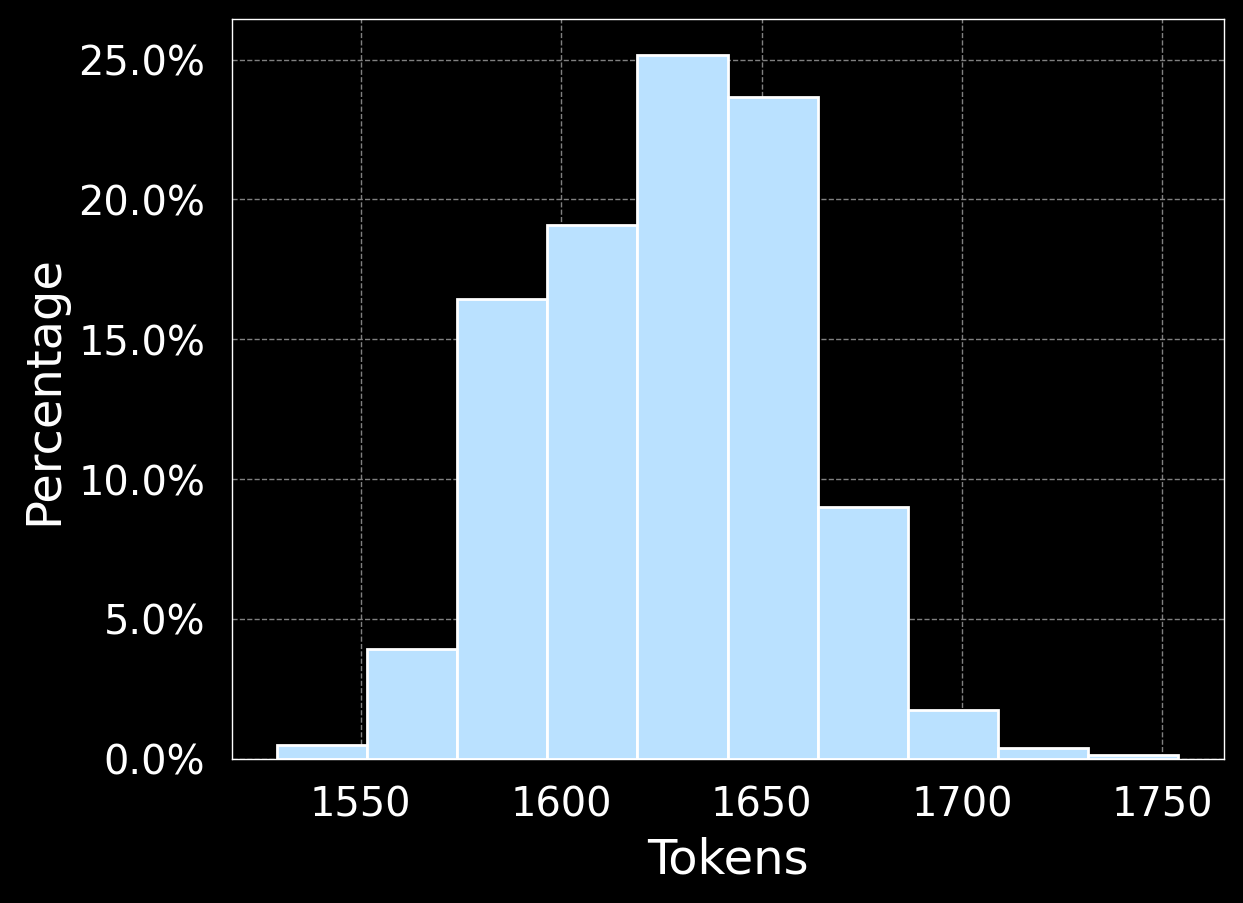

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show();

In [29]:
# Find rows where token count exceeds 2048
df_long_tokens = df[df["token_count"] > 2048]

print(f"Number of rows with token count > 2048: {len(df_long_tokens)}")

df_long_tokens.head()

Number of rows with token count > 2048: 0


,instruction,input,usefulness_score,text,token_count


In [38]:
#df = df[df["token_count"] <= 1024].copy()

In [39]:
#print(f"Number of rows after filtering (token_count ≤ 1024): {len(df)}")

Number of rows after filtering (token_count ≤ 1024): 2516


In [30]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset

train, temp = train_test_split(df, test_size=0.2, random_state=42)  # 80% train, 20% temp
val, test = train_test_split(temp, test_size=0.5, random_state=42)  # 50% val, 50% test

In [31]:
print(len(train), len(val), len(test))

2436 305 305


In [32]:
train.to_json("train.json", orient="records", lines=True)
val.to_json("val.json", orient="records", lines=True)
test.to_json("test.json", orient="records", lines=True)

In [33]:
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [34]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 2436
    })
    validation: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 305
    })
    test: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 305
    })
})

In [35]:
print(dataset["train"][0]["text"])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

**Task:**
You are a search quality rater evaluating the usefulness of clicked documents based on the following information:

a. User ID: Unique user ID
b. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
c. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
d. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
e. Query: User submitted query.
f. Query Position: The sequential order of the query within the task session, indicating when it was submitted relative to other queries.
g. Query Dwell Time (ms): Time spent on a specific query.
h. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
i. ID: Unique ID for each row.
j. Clicked Documents: User clicked URL.
k. Title: Title of the clicked documents.
l. Summary

In [36]:
from textwrap import dedent
from transformers import AutoTokenizer

In [37]:
from transformers import pipeline  # import pipeline

pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)

Device set to use cuda:0


# TESR PIPELINE WITH PROMPT

In [39]:
def create_test_prompt(row):
    prompt = dedent(
        f"""
{row["instruction"]}

Information:

```
{row["input"]}
```

Based on the above information, output only one integer from 0 to 3 indicating usefulness score. DO NOT PROVIDE ADDITIONAL TEXT, REASONING, EXAMPLES, OR CODE.

Response Format: [Usefulness Score]
"""
    )
    messages = [
        {
            "role": "system",
            "content": dedent(
                """
**Task:**
You are a search quality rater evaluating the usefulness of clicked documents based on the following information:

a. User ID: Unique user ID
b. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
c. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
d. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
e. Query: User submitted query.
f. Query Position: The sequential order of the query within the task session, indicating when it was submitted relative to other queries.
g. Query Dwell Time (ms): Time spent on a specific query.
h. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
i. ID: Unique ID for each row.
j. Clicked Documents: User clicked URL.
k. Title: Title of the clicked documents.
l. Summary: Brief description of the clicked documents on the web page.
m. Rank: Rank of clicked documents on the SERP labeled as 1(high)~30(low).
n. Task Relevance: Relevance of clicked documents to the user’s task labeled as 0 (low)~3 (high).
o. Query Relevance: Relevance of clicked documents to the user’s query labeled as 0 (low)~3 (high).
p. CTR: The percentage of clicks a document (URL) receives out of total interactions within a specific task and query.
q. URL Dwell Time (ms): Time spent on a clicked document.
r. Average URL Dwell Time (ms): Average time a user sepnds across all clicked document on individual task.

You must analyze each task session by considering all the information given above and for each clicked document (URL), provide a usefulness score on an integer scale of 0 to 3 with the following meanings:
3 = Very Useful, very helpful for this query
2 = Fairly Useful, fairly helpful for this query
1 = Somewhat Useful, maybe partly helpful but might contain other irrelevant content
0 = Not Useful at all, should never be shown for this query

**Instructions:**
For each clicked documents <URL> under a specific task <TASK_ID> and user <USER>, use the following rubrics while assigning usefulness score:

Score 3: Very Useful
- Relevance Criteria:
   - Task Relevance: 2–3, Query Relevance: 2–3.
- Satisfaction Criteria:
   - Task and Query Satisfaction: 4–5.
- User Behavior Metrics:
   - Dwell Time: Above average, CTR: High.
- Title & Summary Alignment:
   - High Alignment (>0.5) with Query and Task.
- Exceptional Cases:
   - High satisfaction supports high usefulness even with low relevance.
   - High dwell time supports high usefulness even with low CTR and low relevance.
   - Despite low alignment, some contents provide unexpected useful information.

Score 2: Fairly Useful
- Relevance Criteria:
   - Task Relevance: 1–2, Query Relevance: 1–2.
- Satisfaction Criteria:
   - Task and Query Satisfaction: 3–4.
- User Behavior Metrics:
   - Dwell Time: Around average, CTR: Medium.
- Title & Summary Alignment:
   - Moderate Alignment (0.3–0.5) with Query or Task.
- Exceptional Cases:
   - Users found content useful but lacking depth, that lead to high relevance but fairly useful cases.
   - Moderate engagement supports moderate usefulness when content is relevant but incomplete.

Score 1: Somewhat Useful
- Relevance Criteria:
   - Task Relevance: 1, Query Relevance: 1.
- Satisfaction Criteria:
   - Task and Query Satisfaction: 2–3.
- User Behavior Metrics:
   - Dwell Time: Below average, CTR: Low.
- Title & Summary Alignment:
   - Low Alignment (<0.3) with Query or Task.
- Exceptional Cases:
   - Low satisfaction supports low usefulness even with high relevance.
   - Dwell Time: Below average, CTR: Low means users clicked expecting relevance but left quickly, indicating lack of depth and low usefulness.
   - Misleading title-query match leads to high relevance and low usefulness cases.

Score 0: Not Useful
- Relevance Criteria:
   - Task Relevance: 0, Query Relevance: 0.
- Satisfaction Criteria:
   - Task and Query Satisfaction: 1–2.
- User Behavior Metrics:
   - Dwell Time: Minimal, CTR: Very Low.
- Title & Summary Alignment:
   - No Alignment (<0.2) with Query or Task.
   - Low alignment with high usefulness indicates LR-HU.
- Exceptional Cases:
   - Very low satisfaction confirms low relevance and low usefulness cases.
   - Dwell Time: Minimal, CTR: Very Low means users abandoned the page quickly due to irrelevance leading to low usefulness.
   - Low dwell time with high CTR indicates low usefulness even with high relevance.
   - No Alignment (<0.2) with Query or Task means vontent is completely off-topic, reinforcing low relevance and low usefulness cases.
   
Take a step back and reflect carefully on how best to solve your task. Understand the entire rubrics first and then decide on the usefulness scores analyzing the metrics. Directly output the usefulness score for unique ID <ID> as an integer value in the format:
[Usefulness Score]

DO NOT PROVIDE ADDITIONAL TEXT, REASONING, EXAMPLE, OR CODE. GENERATE USEFULNESS SCORE IN COORECT OUTPUT FORMAT FOR ALL UNIQUE ID.
"""
            ),
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": str(row["usefulness_score"])},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

In [40]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

**Task:**
You are a search quality rater evaluating the usefulness of clicked documents based on the following information:

a. User ID: Unique user ID
b. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
c. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
d. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
e. Query: User submitted query.
f. Query Position: The sequential order of the query within the task session, indicating when it was submitted relative to other queries.
g. Query Dwell Time (ms): Time spent on a specific query.
h. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
i. ID: Unique ID for each row.
j. Clicked Documents: User clicked URL.
k. Title: Title of the clicked documents.
l. Summary

In [41]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["usefulness_score"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     2
prediction: 1

CPU times: user 614 ms, sys: 347 ms, total: 961 ms
Wall time: 960 ms


In [42]:
row = dataset["test"][8]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

**Task:**
You are a search quality rater evaluating the usefulness of clicked documents based on the following information:

a. User ID: Unique user ID
b. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
c. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
d. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
e. Query: User submitted query.
f. Query Position: The sequential order of the query within the task session, indicating when it was submitted relative to other queries.
g. Query Dwell Time (ms): Time spent on a specific query.
h. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
i. ID: Unique ID for each row.
j. Clicked Documents: User clicked URL.
k. Title: Title of the clicked documents.
l. Summary

In [43]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["usefulness_score"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     2
prediction: 2

CPU times: user 456 ms, sys: 212 ms, total: 667 ms
Wall time: 666 ms


# TEST DATASET PREDICTION

In [44]:
rows = []
for row in tqdm(dataset["test"]):
    prompt = create_test_prompt(row)
    outputs = pipe(prompt)
    rows.append(
        {
            "instruction": row["instruction"],
            "input": row["input"],
            "prompt": prompt, 
            "usefulness_score": row["usefulness_score"],
            "untrained_prediction": outputs[0]["generated_text"],
        }
    )

predictions_df = pd.DataFrame(rows)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
100%|██████████| 305/305 [03:24<00:00,  1.49it/s]


# TRAIN ON COMPLETIONS

In [45]:
response_template = "<|end_header_id|>"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

examples = [dataset["train"][0]["text"]]
encodings = [tokenizer(e) for e in examples]

dataloader = DataLoader(encodings, collate_fn=collator, batch_size=1)

In [46]:
batch = next(iter(dataloader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [47]:
batch["labels"]

tensor([[  -100,   -100,   -100,  ...,    271,     17, 128009]])

# LoRA SETUP

In [48]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128264, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((409

In [49]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [50]:
model.print_trainable_parameters()

trainable params: 20,971,520 || all params: 8,051,298,304 || trainable%: 0.2605


In [170]:
!pip install -U tensorboard

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 165.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 185.1 MB/s eta 0:00:00


In [51]:
OUTPUT_DIR = "/home/ec2-user/SageMaker/experiments"
LOG_DIR = f"{OUTPUT_DIR}/runs"

%reload_ext tensorboard
%tensorboard --logdir {LOG_DIR} --port=6008 --bind_all

In [52]:
from IPython.display import display, HTML

TENSORBOARD_PORT = 6008  # Change if needed
TENSORBOARD_URL = f"/proxy/{TENSORBOARD_PORT}/"

display(HTML(f"<a href='{TENSORBOARD_URL}' target='_blank'>📊 Click Here to Open TensorBoard</a>"))

In [53]:
sft_config = SFTConfig(
    output_dir=OUTPUT_DIR,
    dataset_text_field="text",
    max_seq_length=2048, 
    num_train_epochs=2.0,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    optim="paged_adamw_8bit",  #Explicitly set 8-bit optimizer
    learning_rate=5.0e-05,
    lr_scheduler_type="cosine",
    eval_strategy="steps",
    eval_steps=50,
    save_steps=50,
    logging_steps=10,
    save_strategy="steps",
    warmup_ratio=0.1,
    save_total_limit=2,
    save_safetensors=True,
    fp16=False,
    bf16=torch.cuda.is_bf16_supported(),
    gradient_checkpointing=True,
    report_to="tensorboard",
    dataset_kwargs={"add_special_tokens": False, 
                    "append_concat_token": False,},
    seed=SEED,
)


trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
)

Map:   0%|          | 0/2436 [00:00<?, ? examples/s]

Map:   0%|          | 0/305 [00:00<?, ? examples/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:402: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


In [54]:
print(trainer.args.optim)


OptimizerNames.PAGED_ADAMW_8BIT


In [55]:
print(f"Optimizer in config: {sft_config.optim}")

Optimizer in config: paged_adamw_8bit


In [56]:
print(sft_config.report_to)

['tensorboard']


In [57]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
50,0.402000,0.407805
100,0.358200,0.348909
150,0.355200,0.349660
200,0.302900,0.346835
250,0.351700,0.333478
300,0.282500,0.332252


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/util

TrainOutput(global_step=304, training_loss=0.35233627495012787, metrics={'train_runtime': 16583.2875, 'train_samples_per_second': 0.294, 'train_steps_per_second': 0.018, 'total_flos': 3.600718998294528e+17, 'train_loss': 0.35233627495012787, 'epoch': 1.9917898193760264})

In [61]:
trainer.save_model(NEW_MODEL)

In [62]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [63]:
!nvidia-smi

Sat Mar 29 08:23:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   28C    P0             59W /  300W |    8895MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Load Trained Model

In [64]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(NEW_MODEL)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,  #4-bit quantization
    device_map="auto",
)

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)
model = PeftModel.from_pretrained(model, NEW_MODEL)
model = model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [65]:
model.push_to_hub(NEW_MODEL, tokenizer=tokenizer, max_shard_size="5GB")

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR-Rubrics/commit/e732bea92fa00e1c3ec16ff6c0a7d93db5f9c406', commit_message='Upload LlamaForCausalLM', commit_description='', oid='e732bea92fa00e1c3ec16ff6c0a7d93db5f9c406', pr_url=None, repo_url=RepoUrl('https://huggingface.co/moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR-Rubrics', endpoint='https://huggingface.co', repo_type='model', repo_id='moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR-Rubrics'), pr_revision=None, pr_num=None)

In [66]:
tokenizer.push_to_hub(NEW_MODEL)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR-Rubrics/commit/e732bea92fa00e1c3ec16ff6c0a7d93db5f9c406', commit_message='Upload tokenizer', commit_description='', oid='e732bea92fa00e1c3ec16ff6c0a7d93db5f9c406', pr_url=None, repo_url=RepoUrl('https://huggingface.co/moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR-Rubrics', endpoint='https://huggingface.co', repo_type='model', repo_id='moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR-Rubrics'), pr_revision=None, pr_num=None)

Evaluation

In [67]:
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 2436
    })
    validation: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 305
    })
    test: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 305
    })
})

In [202]:
!nvidia-smi

Fri Mar 28 18:59:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   31C    P0             62W /  300W |   21439MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [68]:
import torch
import gc

torch.cuda.empty_cache()  #Clears unused VRAM
gc.collect()  #Forces garbage collection

231

# Test New Model

In [69]:
MODEL_NAME = "Llama-3.1-8B-Instruct-Finetuned-THUIR-Rubrics"
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, quantization_config=quantization_config, device_map="auto"
)

ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [70]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)

Device set to use cuda:0


In [71]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

**Task:**
You are a search quality rater evaluating the usefulness of clicked documents based on the following information:

a. User ID: Unique user ID
b. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
c. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
d. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
e. Query: User submitted query.
f. Query Position: The sequential order of the query within the task session, indicating when it was submitted relative to other queries.
g. Query Dwell Time (ms): Time spent on a specific query.
h. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
i. ID: Unique ID for each row.
j. Clicked Documents: User clicked URL.
k. Title: Title of the clicked documents.
l. Summary

In [72]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["usefulness_score"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     2
prediction: 1

CPU times: user 491 ms, sys: 240 ms, total: 732 ms
Wall time: 730 ms


In [73]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)

KeyError: 'answer'

In [74]:
predictions = []
for row in tqdm(dataset["test"]):
    outputs = pipe(create_test_prompt(row))
    predictions.append(outputs[0]["generated_text"])

100%|██████████| 305/305 [03:42<00:00,  1.37it/s]


In [75]:
predictions_df.head()

,instruction,input,prompt,usefulness_score,untrained_prediction
0,Evaluate the usefulness of a search result bas...,\nUser ID: 2017010399 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,2,2
1,Evaluate the usefulness of a search result bas...,\nUser ID: 2018000005 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,2,1
2,Evaluate the usefulness of a search result bas...,\nUser ID: 2015011730 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,3,0
3,Evaluate the usefulness of a search result bas...,\nUser ID: 2015211220 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,1,0
4,Evaluate the usefulness of a search result bas...,\nUser ID: 2013012187 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,2,1


In [76]:
predictions_df["trained_prediction"] = predictions

In [77]:
predictions_df.head()

,instruction,input,prompt,usefulness_score,untrained_prediction,trained_prediction
0,Evaluate the usefulness of a search result bas...,\nUser ID: 2017010399 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,2,2,2
1,Evaluate the usefulness of a search result bas...,\nUser ID: 2018000005 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,2,1,1
2,Evaluate the usefulness of a search result bas...,\nUser ID: 2015011730 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,3,0,0
3,Evaluate the usefulness of a search result bas...,\nUser ID: 2015211220 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,1,0,2
4,Evaluate the usefulness of a search result bas...,\nUser ID: 2013012187 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,2,1,2


In [79]:
predictions_df.to_csv("predictions.csv", index=None)

In [80]:
sample = predictions_df.sample(n=20)
sample.head()

,instruction,input,prompt,usefulness_score,untrained_prediction,trained_prediction
180,Evaluate the usefulness of a search result bas...,\nUser ID: 2018000004 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,3,1,1
154,Evaluate the usefulness of a search result bas...,\nUser ID: 2014012437 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,0,1,1
111,Evaluate the usefulness of a search result bas...,\nUser ID: 2016211684 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,2,1,1
247,Evaluate the usefulness of a search result bas...,\nUser ID: 2016211684 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,1,2,2
60,Evaluate the usefulness of a search result bas...,\nUser ID: 2013311064 is performing a search t...,<|begin_of_text|><|start_header_id|>system<|en...,3,0,1
